# Rice Leaf Disease using CNN

Of the three major crops – rice, wheat and maize – rice is by far the most important food crop for people in low- and lower-middle-income countries. Although rich and poor people alike eat rice in low-income countries, the poorest people consume relatively little wheat and are therefore deeply affected by the cost and availability of rice.

In many Asian countries, rice is the fundamental and generally irreplaceable staple, especially of the poor. For the extreme poor in Asia, who live on less than dollar 1.25 a day, rice accounts for nearly half of their food expenditures and a fifth of total household expenditures, on average. This group alone annually spends the equivalent of $62 billion (purchasing power parity) on rice. Rice is critical to food security for many of the world’s poor people.

This dataset contains 120 jpg images of disease infected rice leaves. The images are grouped into 3 classes based on the type of disease. There are 40 images in each class.

Classes

Leaf smut

Brown spot

Bacterial leaf blight

## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=40
CHANNELS=3
EPOCH=50


In [3]:
data=tf.keras.preprocessing.image_dataset_from_directory('Rice _Leaf',
                                                    shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE)

Found 119 files belonging to 3 classes.


In [4]:
class_names=data.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

In [5]:
for image_batch,label_batch in data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(40, 256, 256, 3)
[1 2 0 0 0 2 0 2 0 2 2 2 1 0 0 0 1 0 0 1 2 1 0 2 1 0 2 2 0 0 0 1 0 1 0 1 2
 0 2 2]


In [6]:
for image_batch,label_batch in data.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


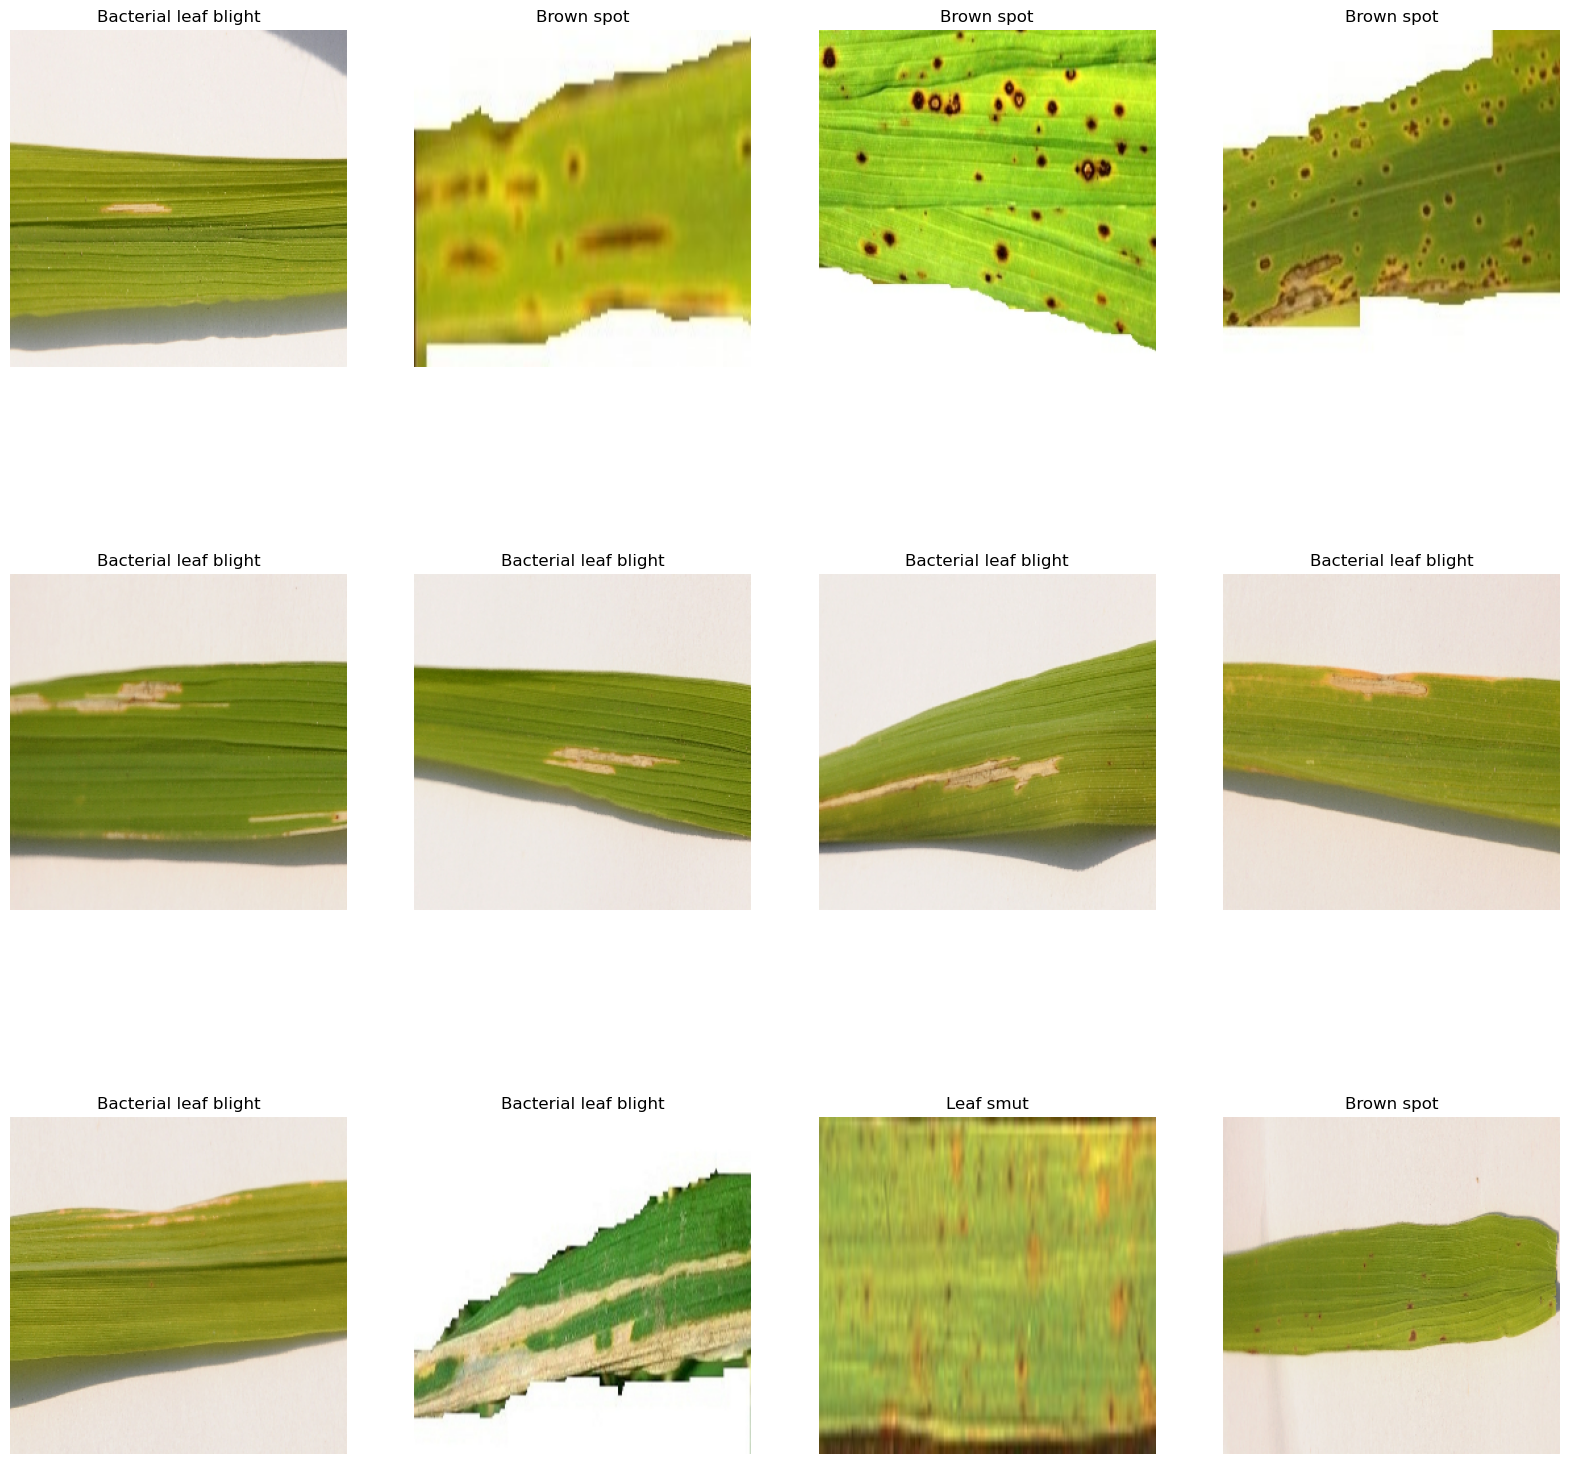

In [7]:
# printing the first image

plt.figure(figsize=(20,20))
for image_batch,label_batch in data.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
      
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])  # label_batch will give no to get the name we'll put class_names as index
        plt.axis('off')  # remove the numbers from the axis
    

## Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

    1.Training: Dataset to be used while training

    2.Validation: Dataset to be tested against while training

    3.Test: Dataset to be tested against after we trained a model

In [8]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)  # seed is to predict
    
    train_size= int(train_split * ds_size)
    val_size= int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(data) 

# Data Preprocessing 

## Cache,Shuffle,Prefetch the Data

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Resizing and Rescaling the model

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),])

## Data Augmentation

In [85]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),])

In [95]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape) #softmax normalizes the probability of classes



In [96]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_44 (Conv2D)          (40, 254, 254, 32)        896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (40, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (40, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (40, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (40, 60, 60, 64)        

## Compiling the model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric



In [97]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [98]:
history=model.fit(
     train_ds,
     epochs=EPOCH,
     batch_size=BATCH_SIZE,
     verbose=1,
    validation_data=val_ds)

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 1.1092 - accuracy: 0.3750
Epoch 2/50
2/2 [==============================] - 3s 2s/step - loss: 1.0919 - accuracy: 0.3750
Epoch 3/50
2/2 [==============================] - 3s 2s/step - loss: 1.0870 - accuracy: 0.3750
Epoch 4/50
2/2 [==============================] - 3s 2s/step - loss: 1.0724 - accuracy: 0.3750
Epoch 5/50
2/2 [==============================] - 3s 2s/step - loss: 1.0389 - accuracy: 0.3750
Epoch 6/50
2/2 [==============================] - 3s 2s/step - loss: 0.9817 - accuracy: 0.4625
Epoch 7/50
2/2 [==============================] - 3s 2s/step - loss: 0.9561 - accuracy: 0.5375
Epoch 8/50
2/2 [==============================] - 3s 2s/step - loss: 0.9092 - accuracy: 0.5750
Epoch 9/50
2/2 [==============================] - 3s 2s/step - loss: 0.8675 - accuracy: 0.6125
Epoch 10/50
2/2 [==============================] - 3s 2s/step - loss: 0.8189 - accuracy: 0.6750
Epoch 11/50
2/2 [==============================] 

In [105]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 558ms/step - loss: 0.6103 - accuracy: 0.8205


In [106]:
scores = model.evaluate(train_ds)

2/2 [==============================] - 1s 284ms/step - loss: 0.3702 - accuracy: 0.9000


#### we can see that the test accuracy is 84% ,but the train data is 96% so we can see that the model is underfitting

In [107]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [108]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [109]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
2/2 [==============================] - 4s 2s/step - loss: 1.7827 - accuracy: 0.3500
Epoch 2/50
2/2 [==============================] - 4s 2s/step - loss: 1.4870 - accuracy: 0.3375
Epoch 3/50
2/2 [==============================] - 4s 2s/step - loss: 1.1115 - accuracy: 0.3750
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 1.1010 - accuracy: 0.3750
Epoch 5/50
2/2 [==============================] - 4s 2s/step - loss: 1.0984 - accuracy: 0.3750
Epoch 6/50
2/2 [==============================] - 4s 2s/step - loss: 1.0842 - accuracy: 0.3750
Epoch 7/50
2/2 [==============================] - 4s 2s/step - loss: 1.0942 - accuracy: 0.3125
Epoch 8/50
2/2 [==============================] - 4s 2s/step - loss: 1.0971 - accuracy: 0.3500
Epoch 9/50
2/2 [==============================] - 4s 2s/step - loss: 1.0863 - accuracy: 0.4125
Epoch 10/50
2/2 [==============================] - 4s 2s/step - loss: 1.0809 - accuracy: 0.4000
Epoch 11/50
2/2 [==============================] 

In [110]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 0s 453ms/step - loss: 0.5248 - accuracy: 0.8462


In [111]:
scores = model.evaluate(train_ds)

2/2 [==============================] - 1s 282ms/step - loss: 0.4855 - accuracy: 0.8875


#### You can see above that we get 84% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [112]:
scores

[0.48549890518188477, 0.887499988079071]

#### Plotting the Accuracy and Loss Curves

In [113]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 2}

In [114]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [115]:
acc = history.history['accuracy']
loss = history.history['loss']

print(acc,'\n')
print(loss)

[0.3499999940395355, 0.3375000059604645, 0.375, 0.375, 0.375, 0.375, 0.3125, 0.3499999940395355, 0.4124999940395355, 0.4000000059604645, 0.375, 0.375, 0.38749998807907104, 0.42500001192092896, 0.5249999761581421, 0.44999998807907104, 0.44999998807907104, 0.5249999761581421, 0.5625, 0.5249999761581421, 0.6625000238418579, 0.5625, 0.550000011920929, 0.6625000238418579, 0.6499999761581421, 0.699999988079071, 0.7124999761581421, 0.699999988079071, 0.762499988079071, 0.6875, 0.7250000238418579, 0.699999988079071, 0.762499988079071, 0.762499988079071, 0.800000011920929, 0.8125, 0.824999988079071, 0.824999988079071, 0.8125, 0.8999999761581421, 0.8125, 0.7749999761581421, 0.800000011920929, 0.824999988079071, 0.862500011920929, 0.7875000238418579, 0.8500000238418579, 0.824999988079071, 0.8999999761581421, 0.824999988079071] 

[1.7827094793319702, 1.4869674444198608, 1.1114907264709473, 1.1009773015975952, 1.0984300374984741, 1.0842478275299072, 1.0942128896713257, 1.0971229076385498, 1.0863336

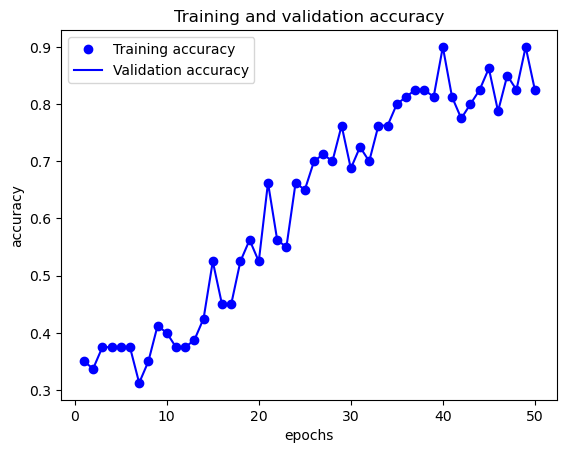

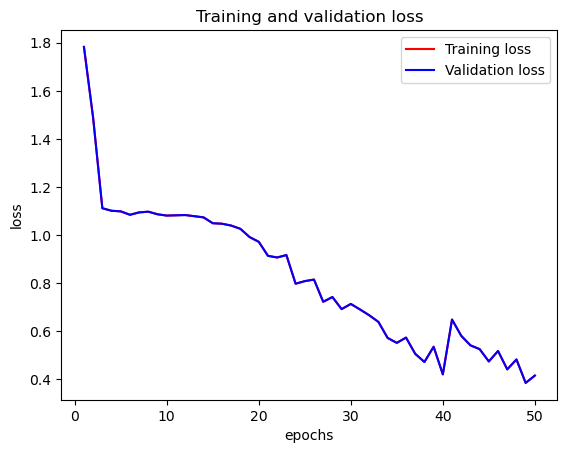

In [116]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["accuracy"]
loss = history.history["loss"]
val_loss = history.history["loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Leaf smut
2/2 [==============================] - 0s 58ms/step
predicted label: Leaf smut


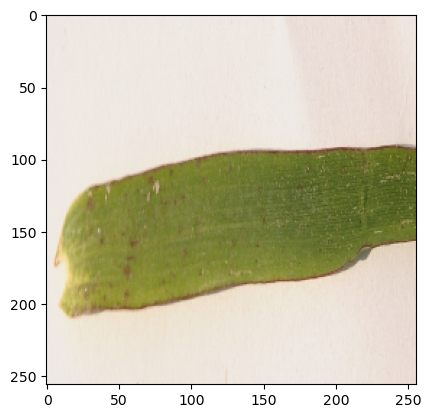

In [117]:
# to check if the model is working well
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Function for inference

In [118]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence   

1/1 [==============================] - 0s 39ms/step


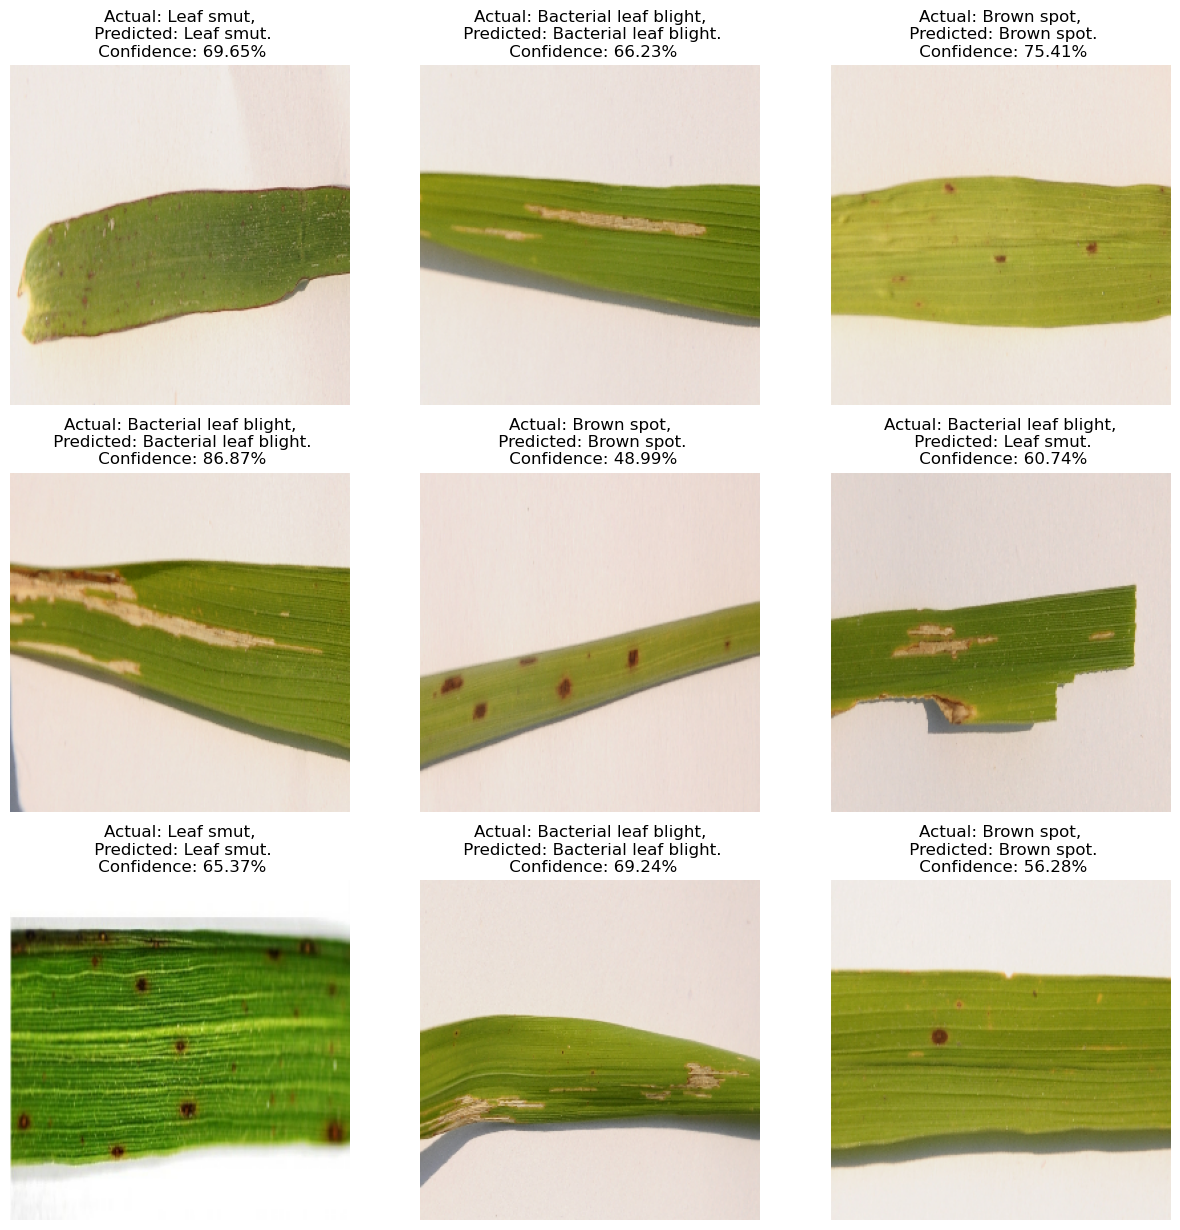

In [119]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Conclusion
The test accuracy is 84%. We have created a best model to identify the three major attacking diseases of rice plants. On the positive side, we can still scope to improve our model.

## saving the model

In [121]:
model_version=1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets


In [124]:
import os
model_version=os.listdir('../model')

In [125]:
model_version

['1',
 'assets',
 'fingerprint.pb',
 'keras_metadata.pb',
 'saved_model.pb',
 'variables']